This script calculates the yearly likelihood that a 95th percentile wind will occur when antecedent conditions are dry, using reanalysis data.

Dry conditions are defined as a 2-week period where total precipitation is less than 12mm for each grid cell.

The calculation part was run on the server. It can be run locally but will be quite slow and use a lot of memory.


In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import cftime
import pandas as pd
import cftime
import numpy as np
import netCDF4
import os
import cartopy.feature as cfeature
import scipy.stats as stats
from netCDF4 import Dataset
import h5py
coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "
/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


## Calculate Dry Wind

In [15]:
model_directory = '/'
directory = model_directory+'/pr/'
pr_dir = directory+'/'+'era5_pr_1981_2010.nc'
directory = model_directory+'/'+'/sfcWind/'
sfcWind_dir = directory+'/'+'era5_sfcWind_1981_2010.nc'
pr = xr.open_dataset(pr_dir)
sfcWind = xr.open_dataset(sfcWind_dir)

In [16]:
sfcWind_vals = sfcWind.wspd10mean
pr_vals = pr.prec

# calculating wind percentiles based on one year might cause issues, you need the entire dataset

testing_percentile = .95

months = [7,8,9,10,11]
time_index = [i for i, month in enumerate(pr_vals.day.dt.month) if month in months]
new_dataset = pr_vals.isel(day = time_index)
window = 14
shifted = new_dataset.rolling(day=window,center=False).construct("window")
trailprtotal = shifted.sum(dim='window')

months = [8,9,10,11]
time_index = [i for i, month in enumerate(trailprtotal.day.dt.month) if month in months]
trailprtotal = trailprtotal.isel(day = time_index)

UV = sfcWind_vals
wind_prctiles = UV.quantile(testing_percentile,dim="day")

# find cooccurence of strong wind and dry conditions
# make sure the time periods are the same
months = [8,9,10,11]
time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
UV = UV.isel(day = time_index)

wd = xr.where(UV > wind_prctiles,1,0)

drycond = xr.where(trailprtotal < 12,1,0)
wetcond = xr.where(trailprtotal >= 12,1,0)

wd = wd.rename({'day':'time'})
drycond = drycond.rename({'day':'time'})
wetcond = wetcond.rename({'day':'time'})

In [ ]:
hist_fire_occurences = []
total_wind_occurences = []
for i in range(len(wd.groupby('time.year'))):
    testyear = 1981+i
    wd_testing_year = wd.sel(time=wd.time.dt.year.isin([testyear]))
    drycond_testing_year = drycond.sel(time=drycond.time.dt.year.isin([testyear]))

    # Initialize an array of zeros with dimensions of latitude and longitude
    result = np.zeros_like(wd_testing_year.isel(time=0))

    result2 = np.zeros_like(wd_testing_year.isel(time=0))

    for time_index in range(len(wd_testing_year.time)):
        # Get the time slice for both wd_testing_year and drycond_testing_year
        wd_slice = wd_testing_year.isel(time=time_index)
        drycond_slice = drycond_testing_year.isel(time=time_index)

        # Check where both arrays are equal to 1
        mask = (wd_slice == 1) & (drycond_slice == 1)
    
        # count total dry wind
    
        dry_wind = wd_slice == 1

        # Count the number of occurrences where the mask is True and increment the result array
        result += mask
    
        result2 += dry_wind
    # Convert the result array to an xarray DataArray
    result_dataarray = xr.DataArray(result, coords={"lat2d": wd_testing_year.lat2d, "lon2d": wd_testing_year.lon2d}, dims=("lat2d", "lon2d"))
    dw_array = xr.DataArray(result2, coords={"lat2d": wd_testing_year.lat2d, "lon2d": wd_testing_year.lon2d}, dims=("lat2d", "lon2d"))
    hist_fire_occurences.append(result_dataarray)
    total_wind_occurences.append(dw_array)
hist_fire_occurences = xr.concat(hist_fire_occurences,dim='newyear')
hist_fire_occurences_mean = hist_fire_occurences.mean(dim='newyear')

hist_wind_occurence = xr.concat(total_wind_occurences,dim='newyear')

# instead of calculating occurences per year, count dry wind occurences/wind occurences

data_dict_hist = {'total_wind':hist_wind_occurence,'dry_wind_mean_per_year': hist_fire_occurences_mean,'dry_wind_total':hist_fire_occurences}
dataset_hist = xr.Dataset(data_dict_hist)

efwh_file = '/era5/era5_1981_2010_95_total_occurence.nc'
dataset_hist.to_netcdf(efwh_file)

# Plotting

In [2]:
model_directory = '/'
era5_file = model_directory+'/era5/era5_1981_2010_95_total_occurence.nc'
fw_dataset = xr.open_dataset(era5_file)
total_wind = fw_dataset.total_wind.sum(dim='newyear')
dry_wind = fw_dataset.dry_wind_total.sum(dim='newyear')
proportion_era5 = dry_wind/total_wind

In [3]:
# Build some custom colormaps
import matplotlib.colors

segment_map_new = matplotlib.colors.ListedColormap(["darkslateblue","steelblue","teal","darkseagreen","lightgreen","lemonchiffon","khaki","coral","indianred","firebrick"])


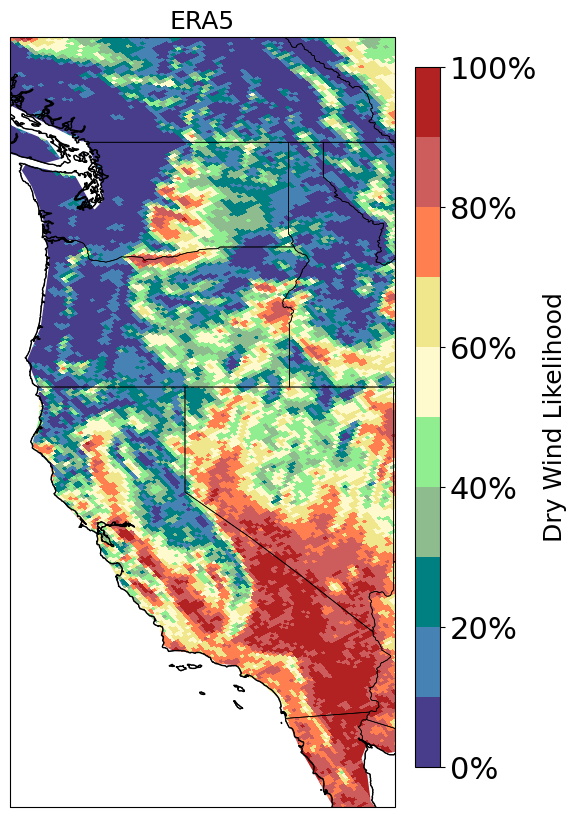

In [4]:
# plot historical pr
fig = plt.figure(figsize=[10,10])
ax = plt.subplot(1,1,1,projection = ccrs.PlateCarree())
im = plt.pcolormesh(coords['lon2d'],coords['lat2d'],proportion_era5,cmap=segment_map_new)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '110m', edgecolor='face', facecolor='white')
ax.add_feature(ocean)
#plt.colorbar(im)
#plt.pcolormesh(nds['lon2d'],nds['lat2d'],nds['wspd10mean'].isel(day=1))
ax.coastlines()
ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=.5)
ax.set_ylim(30,52)
ax.set_xlim(-125,-114)
plt.title('ERA5',fontsize=18)
#plt.title('Likelihood of Fall Dry Conditions and Strong Wind \n (ERA5 1981-2010)',fontsize=10)
cbar_ax = fig.add_axes([0.725, 0.15, 0.025, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
new_ticks = np.linspace(0, 1, 6)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]

cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.ax.tick_params(labelsize=22) 
cbar.set_label('Dry Wind Likelihood', rotation=90,fontsize=18)
plt.show()